In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
video_dir = 'Dados/AutoEstrada.avi'

video = cv2.VideoCapture(video_dir)
num_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
fps = video.get(cv2.CAP_PROP_FPS)

### Estimação da imagem de fundo

In [3]:
bg_video = []
information = []
for i in range(num_frames):
    flag, frame = video.read()
    if flag:
        bg_video.append(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))

In [4]:
def median_image(video):
    median = np.median(video,axis=0).astype(dtype = np.uint8)
    cv2.imwrite('bg.jpg',median)
    return median

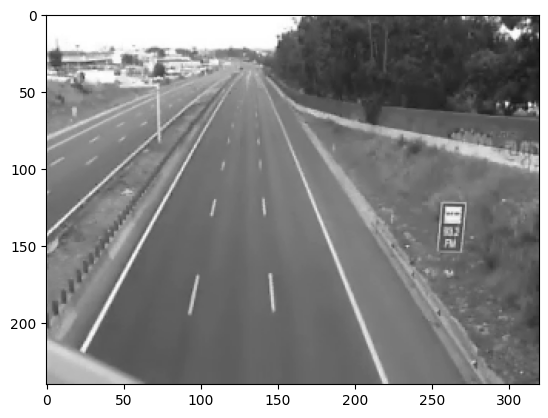

In [5]:
bg_image = median_image(bg_video)
plt.imshow(cv2.cvtColor(bg_image, cv2.COLOR_BGR2RGB))

In [6]:
N_LINHAS  = 240
N_COLUNAS = 320

KERNEL         = (15,15)
STR_ELEM_SIZE1 = (3,3)
STR_ELEM_SIZE2 = (5,5)
ANCHOR_POS     = (-1,-1)

BIN_TH = 18

VERDE    = (0, 255, 0)
AZUL     = (255,0,0)
PRETO    = (0,0,0)
BRANCO   = (255,255,255)

CENTROID_RADIUS = 2

TEXT_OFFSET_X  = 0
TEXT_OFFSET_Y  = -5
TEXT_SCALE     = 0.5
LINE_THICKNESS = 2


AREA = np.array([[215,225],[22,225],[100,80],[155,80]], dtype= np.int32)
aux_image = np.empty((N_LINHAS, N_COLUNAS), dtype=np.uint8)

In [7]:
def scouting_contour(aux_image, AREA, STR_ELEM_SIZE, ANCHOR_POS, N_LINHAS, N_COLUNAS):
    
    cv2.polylines(aux_image, [AREA], True, 255, 2, lineType=cv2.FILLED) 
    # aplicar filtro de suavização Gaussiano
    aux_image = cv2.GaussianBlur(aux_image, STR_ELEM_SIZE, sigmaX=0) 
    # binarização
    aux_bin   = cv2.threshold(aux_image, 0, 255, cv2.THRESH_OTSU)[1] 
    
    # erosão
    aux_bin   = cv2.erode(aux_bin, (1,1), anchor=ANCHOR_POS)   
    
    cnts_zone = cv2.findContours(aux_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
    mask      = np.zeros((N_LINHAS, N_COLUNAS))
    cv2.fillPoly(mask, [AREA], 255)

    mask_bin = cv2.threshold(mask, 127, 1, cv2.THRESH_BINARY)[1]
    return cnts_zone[0], mask_bin.astype(np.uint8)

In [8]:
CNT_ZONA, mask = scouting_contour(aux_image, AREA, STR_ELEM_SIZE2, ANCHOR_POS, N_LINHAS, N_COLUNAS)


In [9]:
#load dos dados novamente
video_dir = 'Dados/AutoEstrada.avi'

video = cv2.VideoCapture(video_dir)
num_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
fps = video.get(cv2.CAP_PROP_FPS)

TH_CARRO     = 30
dict_carros  = {}
carro_atual  = 1

In [10]:
for i in range(num_frames):

    flag, frame = video.read()
    
    if flag :
        # converter a frame para níveis de cinzento
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # deteção de pixeis ativos atraves da diferença da frame de fundo com a frame atual
        dif = cv2.absdiff(bg_image, gray_frame)

        # blur para suavizar a frame de diferença
        dif_blur = cv2.GaussianBlur(dif, KERNEL, sigmaX=0)

        # binarizaçao da frame de diferença
        th, dif_bin = cv2.threshold(dif_blur, BIN_TH, 255, cv2.THRESH_BINARY)

        # criação de elementos estruturantes
        str_elem1 = cv2.getStructuringElement(cv2.MORPH_RECT, STR_ELEM_SIZE1, anchor=ANCHOR_POS)
        str_elem2 = cv2.getStructuringElement(cv2.MORPH_RECT, STR_ELEM_SIZE2, anchor=ANCHOR_POS)

        # aplicação de operadores morfológicos
        dif_bin2 = cv2.erode(dif_bin, str_elem1, anchor=ANCHOR_POS)
        dif_bin3 = cv2.dilate(dif_bin2, str_elem2, anchor=ANCHOR_POS)

        # aplicação da máscara da zona
        mask_bin = cv2.multiply(mask, dif_bin3)

        # deteção de contornos
        cnts = cv2.findContours(mask_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[0]

        # desenho da zona
        zone = cv2.polylines(frame, [AREA], True, AZUL, LINE_THICKNESS, lineType=cv2.FILLED)
    
        for cnt in reversed(cnts): # para que os contornos sejam contados de cima para baixo
            
            (x,y,w,h) = cv2.boundingRect(cnt) # bounding box
            centroide = cv2.minEnclosingCircle(cnt)[0] # centroide

            num_carro    = 0
            carro        = np.array([centroide[0], centroide[1]], dtype=np.int32)
            array_carros = np.array(list(dict_carros.values()))[np.argsort(np.array(list(dict_carros.keys())))]

            # verificar se o centroide esta dentro da zona de decisão
            if cv2.pointPolygonTest(CNT_ZONA[0], centroide, measureDist=False) > 0:
                
                if array_carros.shape[0] == 0: # quando ainda não existem veiculos identificados
                    dict_carros[carro_atual] = carro
                    carro_atual += 1
                else:# quando já existem veiculos identificados
                    dists = np.sqrt(np.sum((array_carros-carro)**2, axis=1))
                    idx   = np.argmin(dists)
                    d_min = dists[idx]
                    num_carro = idx + 1

                    if d_min <= TH_CARRO:
                        dict_carros[num_carro] = carro
                    else:
                        dict_carros[carro_atual] = carro
                        carro_atual += 1
                
                if carro[1] > 80 + 5:
                    cv2.putText(frame, str(num_carro), (x+ TEXT_OFFSET_X, y + TEXT_OFFSET_Y), cv2.FONT_HERSHEY_SIMPLEX, TEXT_SCALE, PRETO, LINE_THICKNESS)
                    cv2.rectangle(frame, (x, y), (x + w, y + h), VERDE, LINE_THICKNESS)
                    cv2.circle(frame, (carro[0], carro[1]), CENTROID_RADIUS, BRANCO, LINE_THICKNESS)

        cv2.imshow('Detecao de Veiculos', frame)

        key = cv2.waitKey(int(1.0/fps*1000))
        if key == 27: # tecla escape
            break

cv2.destroyAllWindows()
        